## GRUPO 8 

#### *Integrantes:* 

1. Gianfranco Soria (20163509)
2. Erick Morales (20163041)
3. Andrea Clavo (20176040)
4. Sandra Martínez (20173026)

# An inferential problem: The Gender Wage Gap
___

### * *Question 1*
___

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

## Data analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.

In [2]:
load("../data/wage2015_subsample_inference.Rdata")
attach(data) 

dim(data)

The following objects are masked from data (pos = 3):

    ad, clg, exp1, exp2, exp3, exp4, hsg, ind, ind2, lwage, mw, ne,
    occ, occ2, scl, sex, shs, so, wage, we



[1] 5150   20

We focus on the subset of college-educated workers (scl, clg variables).

In [3]:
data <- data[data$scl==1 |data$clg==1,]
dim(data)

[1] 3068   20

We can notice that the number of observations decreases. This change is reasonable because we are using a subset.

To start our (causal) analysis, we compare the sample means given gender:

In [4]:
library(xtable)

Z <- data[which(colnames(data) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]

data_female <- data[data$sex==1,]
Z_female <- data_female[which(colnames(data) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]


data_male <- data[data$sex==0,]
Z_male <- data_male[which(colnames(data) %in% c("lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"))]

table <- matrix(0, 12, 3)
table[1:12,1]   <- as.numeric(lapply(Z,mean))
table[1:12,2]   <- as.numeric(lapply(Z_male,mean))
table[1:12,3]   <- as.numeric(lapply(Z_female,mean))
rownames(table) <- c("Log Wage","Sex","Less then High School","High School Graduate","Some College","Gollage Graduate","Advanced Degree", "Northeast","Midwest","South","West","Experience")
colnames(table) <- c("All","Men","Women")
tab<- xtable(table, digits = 4)
tab

,All,Men,Women
Log Wage,3.0000223,3.0384121,2.9569035
Sex,0.4709909,0.0000000,1.0000000
Less then High School,0.0000000,0.0000000,0.0000000
High School Graduate,0.0000000,0.0000000,0.0000000
Some College,0.4667536,0.4818238,0.4498270
Gollage Graduate,0.5332464,0.5181762,0.5501730
Advanced Degree,0.0000000,0.0000000,0.0000000
Northeast,0.2659713,0.2612446,0.2712803
Midwest,0.2858540,0.2908195,0.2802768
South,0.2216428,0.2285890,0.2138408


In particular, the table above shows that the difference in average *logwage* between men and women is equal to $0,081$

In [5]:
mean(data_female$lwage)-mean(data_male$lwage)

[1] -0.08150856

Thus, the unconditional gender wage gap is about $8.15$\% for the group of never married workers (women get paid less on average in our sample). We also observe that never married working women are relatively more educated than working men and have more working experience.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

We verify this by running an ols regression in R.

In [6]:
library(sandwich)
nocontrol.fit <- lm(lwage ~ sex, data=data)
nocontrol.est <- summary(nocontrol.fit)$coef["sex",1]
HCV.coefs <- vcovHC(nocontrol.fit, type = 'HC');
nocontrol.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors

# print unconditional effect of gender and the corresponding standard error
cat ("The estimated gender coefficient is",nocontrol.est," and the corresponding robust standard error is",nocontrol.se)

The estimated gender coefficient is -0.08150856  and the corresponding robust standard error is 0.01957965

Note that the standard error is computed with the *R* package *sandwich* to be robust to heteroskedasticity. 


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Let us run the ols regression with controls.

In [80]:
# Ols regression with controls

flex <- lwage ~ sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)

#   Note that ()*() operation in formula objects in R creates a formula of the sort:
#  (exp1+exp2+exp3+exp4)+ (shs+hsg+scl+clg+occ2+ind2+mw+so+we) +  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)
#  This is not intuitive at all, but that's what it does.

control.fit <- lm(flex, data=data)
control.est <- summary(control.fit)$coef[2,1]

summary(control.fit)

cat("Coefficient for OLS with controls", control.est)

HCV.coefs <- vcovHC(control.fit, type = 'HC');
control.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors


Call:
lm(formula = flex, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.87897 -0.27894 -0.00777  0.25823  2.85755 

Coefficients: (16 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.6856233  0.5060297   7.283  4.2e-13 ***
sex         -0.0530623  0.0193532  -2.742 0.006149 ** 
exp1        -0.1840774  0.1961271  -0.939 0.348036    
exp2         4.0888929  2.3488332   1.741 0.081824 .  
exp3        -2.2064389  1.0068217  -2.191 0.028497 *  
exp4         0.3378726  0.1370444   2.465 0.013744 *  
shs                 NA         NA      NA       NA    
hsg                 NA         NA      NA       NA    
scl         -0.2498673  0.1237850  -2.019 0.043627 *  
clg                 NA         NA      NA       NA    
occ22        0.2151993  0.1582208   1.360 0.173900    
occ23        0.0487642  0.2095297   0.233 0.815986    
occ24        0.0281449  0.2300084   0.122 0.902619    
occ25       -0.2711807  0.3944

Coefficient for OLS with controls -0.05306234

The estimated regression coefficient $\beta_1\approx-0.0696$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $4$\% for women increases to about $7$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

In [8]:
# Partialling-Out using ols

# models
flex.y <- lwage ~  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we) # model for Y
flex.d <- sex ~ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we) # model for D

# partialling-out the linear effect of W from Y
t.Y <- lm(flex.y, data=data)$res
# partialling-out the linear effect of W from D
t.D <- lm(flex.d, data=data)$res

# regression of Y on D after partialling-out the effect of W
partial.fit <- lm(t.Y~t.D)
partial.est <- summary(partial.fit)$coef[2,1]

cat("Coefficient for D via partialling-out", partial.est)

# standard error
HCV.coefs <- vcovHC(partial.fit, type = 'HC')
partial.se <- sqrt(diag(HCV.coefs))[2]

# confidence interval
confint(partial.fit)[2,]

Coefficient for D via partialling-out -0.05306234

2.5 %      97.5 % 
-0.08957070 -0.01655398

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

### * *Question 2*
## Graphics
___

We create two bases: "data_scl" and "data_clg". The goal is to filter the original base and get the actual values in both variables.

In [63]:
data_scl <- data[data$scl==1,]
data_clg <- data[data$clg==1,]

In [64]:
library(dplyr)

Tabla_scl=data_scl%>% 
  group_by(exp1) %>% 
  summarise(Promlwageo = mean(lwage))

Tabla_clg=data_clg%>% 
  group_by(exp1) %>% 
  summarise(Promlwageo = mean(lwage))

We obtain the reported experience levels. We start with "scl".

In [65]:
nivel_scl = c(unique(data_scl$exp1))
nivel_scl = sort(nivel_scl)
length(nivel_scl)

[1] 80

In [66]:
Promedio=rep(0,length(unique(data_scl$exp1)))
length(Promedio)

[1] 80

In [67]:
for (i in 1:80) {Promedio[i]= mean(data_scl$lwage[data_scl$exp1<=nivel_scl[i]])}

In the table you can see the years of experience (exp1) , the average by age (Promlwageo) and the accumulated average (PromMov).

In [68]:
Tabla_scl$PromMov=Promedio
head(Tabla_scl)

exp1,Promlwageo,PromMov
3.0,2.693883,2.693883
3.5,2.729320,2.714895
4.0,2.696418,2.709306
4.5,2.611629,2.680130
5.0,2.727195,2.688087
5.5,2.667625,2.684759


We repeat the procedure for "clg"

In [69]:
nivel_clg = c(unique(data_clg$exp1))
nivel_clg = sort(nivel_clg)
length(nivel_clg)

[1] 40

In [70]:
Promedio=rep(0,length(unique(data_clg$exp1)))
length(Promedio)

[1] 40

In [71]:
for (i in 1:40) {Promedio[i]= mean(data_clg$lwage[data_clg$exp1<=nivel_clg[i]])}
Tabla_clg$PromMov=Promedio
head(Tabla_clg)

exp1,Promlwageo,PromMov
1,3.031143,3.031143
2,3.019492,3.025765
3,3.061553,3.036540
4,3.070771,3.043327
5,3.030900,3.041500
6,3.182292,3.056320


Due to the results of the table, the series "PromMov" turns out to be smoother and closer to the graph to be replicated.

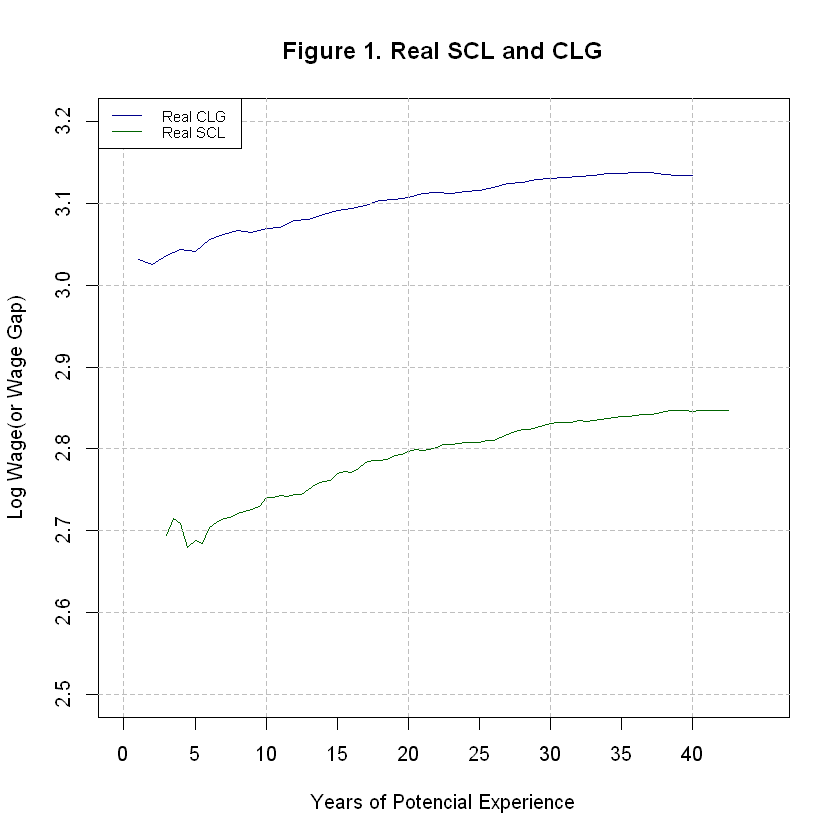

In [203]:
#Figure 1
x = Tabla_clg$exp1
x_1 = Tabla_scl$exp1
y = Tabla_clg$PromMov
y_1 = Tabla_scl$PromMov

plot(x, y, ylim=c(2.5,3.2),type = 'l',xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 1. Real SCL and CLG", xlim=c(0,45),col="darkblue" )    
lines(x_1, y_1,col="darkgreen", type = 'l')
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,43,by=5))
legend(x="topleft",
       legend = c("Real CLG","Real SCL")
       ,col = c("darkblue","darkgreen")
       ,cex=0.75, x.intersp=1.5, y.intersp=0.8, text.width = c(5), 
       lty=c(1,1))

In Figure 1 we can see that both series are not the same size. We note that the CLG series ends earlier. This fact could indicate that people with graduates retire earlier. Likewise, in Figure 1 we could infer that the series are very similar. However, it is necessary to make an individual chart to be more sure.

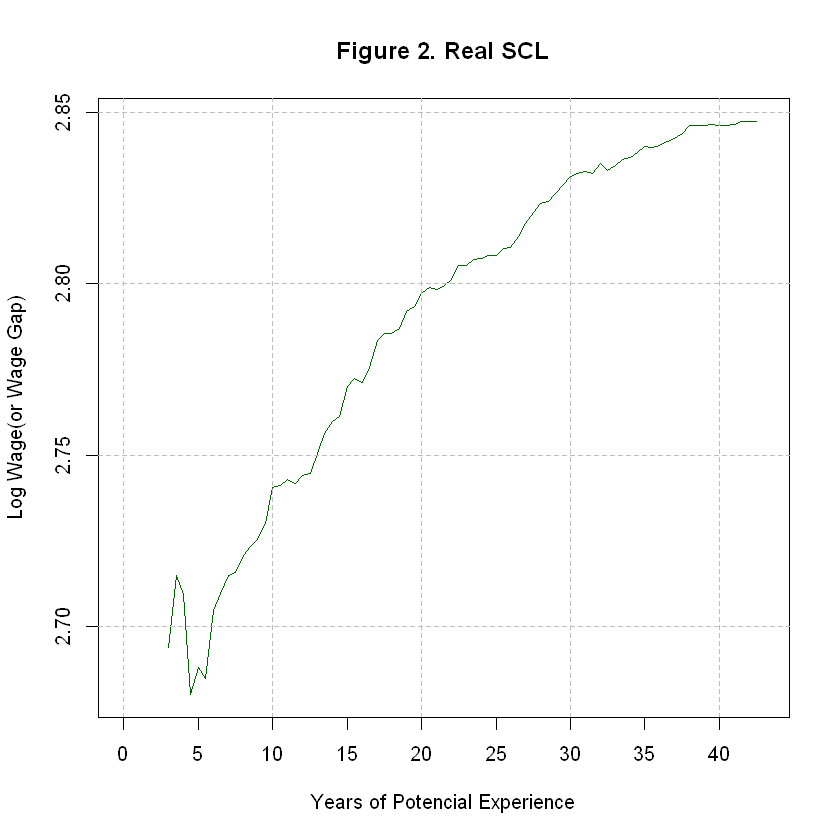

In [194]:
#Figure 2
plot(Tabla_scl$exp1,Tabla_scl$PromMov, xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 2. Real SCL", xlim=c(0,43), xaxt='n',type = 'l',,col="darkgreen",)
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,43,by=5))

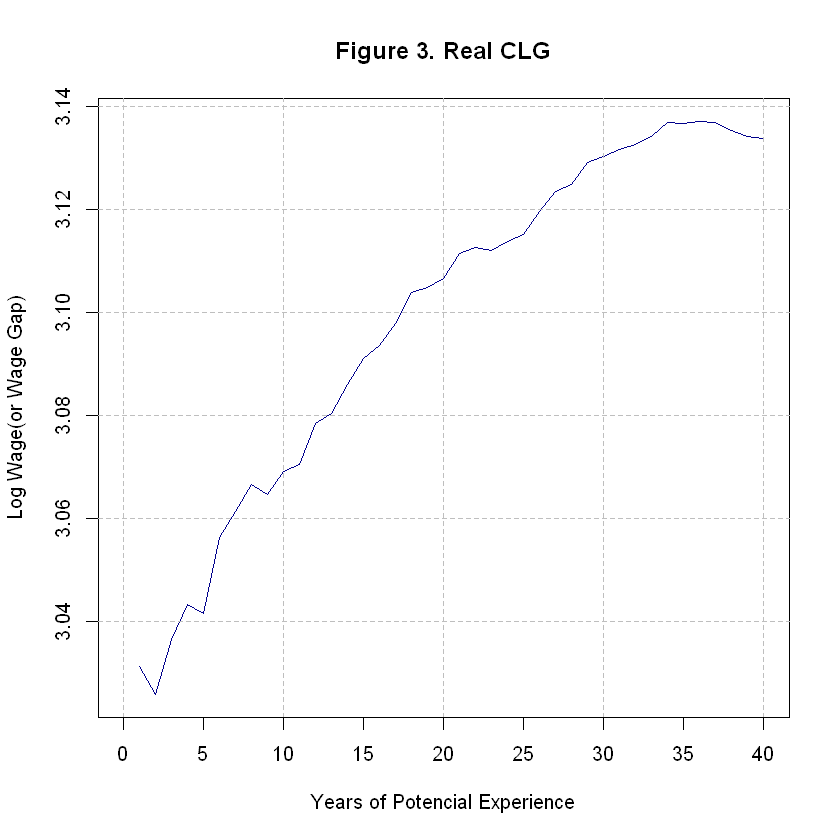

In [195]:
#Figure 3
plot(Tabla_clg$exp1,Tabla_clg$PromMov, xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 3. Real CLG", xlim=c(0,40), xaxt='n',type = 'l',col="darkblue")
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,40,by=5))

From figures 2 and 3 we can notice some differences between the series. These differences are concentrated in the queues. They seem to have similar inclinations. Also, the CLG series seems less noisy.

Now, we will apply the same procedure to separate the bases. But we will graph the values predicted by the regression.

In [163]:
Predict=predict(control.fit)
data$Predict=Predict

In [206]:
data_sclP <- data[data$scl==1,]
data_clgP <- data[data$clg==1,]

library(dplyr)

#Using "sclP"
Tabla_sclP=data_sclP%>% 
  group_by(exp1) %>% 
  summarise(PromPredict = mean(Predict))

nivel_sclP = c(unique(data_sclP$exp1))
nivel_sclP = sort(nivel_sclP)

Promedio=rep(0,length(unique(data_sclP$exp1)))
length(Promedio)
for (i in 1:80) {Promedio[i]= mean(data_sclP$Predict[data_sclP$exp1<=nivel_sclP[i]])}

Tabla_sclP$PromMovP=Promedio
head(Tabla_sclP)

[1] 80

exp1,PromPredict,PromMovP
3.0,2.717265,2.717265
3.5,2.666202,2.686989
4.0,2.695600,2.689593
4.5,2.656527,2.679716
5.0,2.754636,2.692383
5.5,2.710377,2.695309


In [207]:
# We repeat for "clgP"
Tabla_clgP=data_clgP%>% 
  group_by(exp1) %>% 
  summarise(PromPredict = mean(Predict))

nivel_clgP = c(unique(data_clgP$exp1))
nivel_clgP = sort(nivel_clgP)

Promedio=rep(0,length(unique(data_clgP$exp1)))
length(Promedio)
for (i in 1:40) {Promedio[i]= mean(data_clgP$Predict[data_clgP$exp1<=nivel_clgP[i]])}

Tabla_clgP$PromMov=Promedio
head(Tabla_clgP)

[1] 40

exp1,PromPredict,PromMov
1,3.028894,3.028894
2,3.013793,3.021924
3,3.064468,3.034733
4,3.077735,3.043259
5,3.077136,3.048241
6,3.095592,3.053225


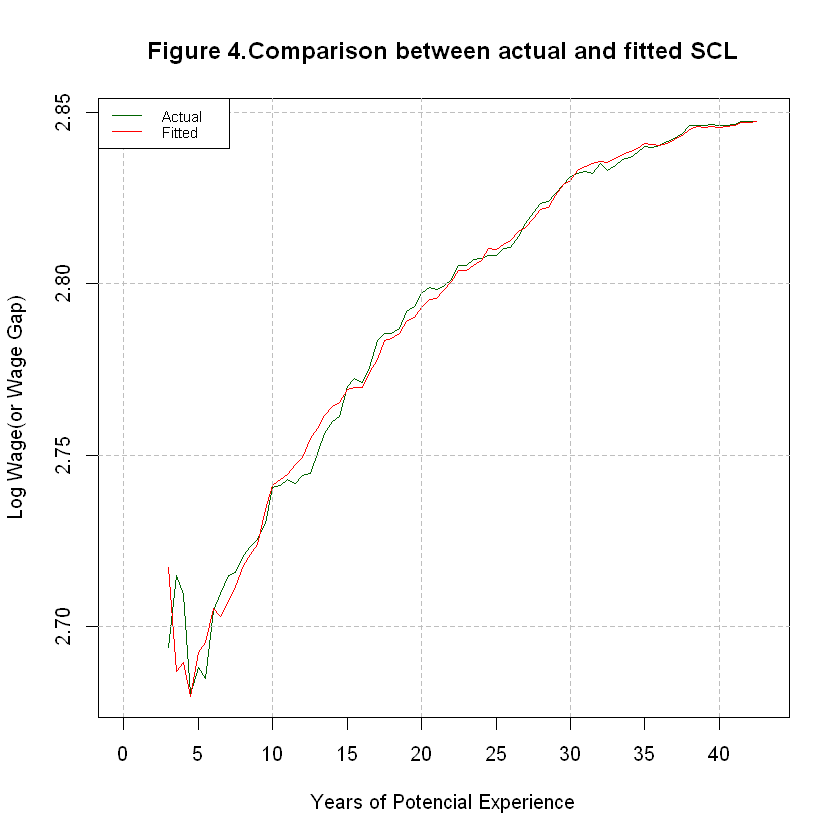

In [210]:
#Figure 4
plot(Tabla_scl$exp1,Tabla_scl$PromMov, xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 4.Comparison between actual and fitted SCL", 
     xlim=c(0,43), xaxt='n',type = 'l', col="darkgreen")
lines(Tabla_sclP$exp1,Tabla_sclP$PromMovP, col="red")
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,43,by=5))
legend(x="topleft",
       legend = c("Actual", "Fitted")
       ,col = c("darkgreen", "red")
       ,cex=0.75, x.intersp=1.5, y.intersp=0.8, text.width = c(4), 
       lty=c(1,1))

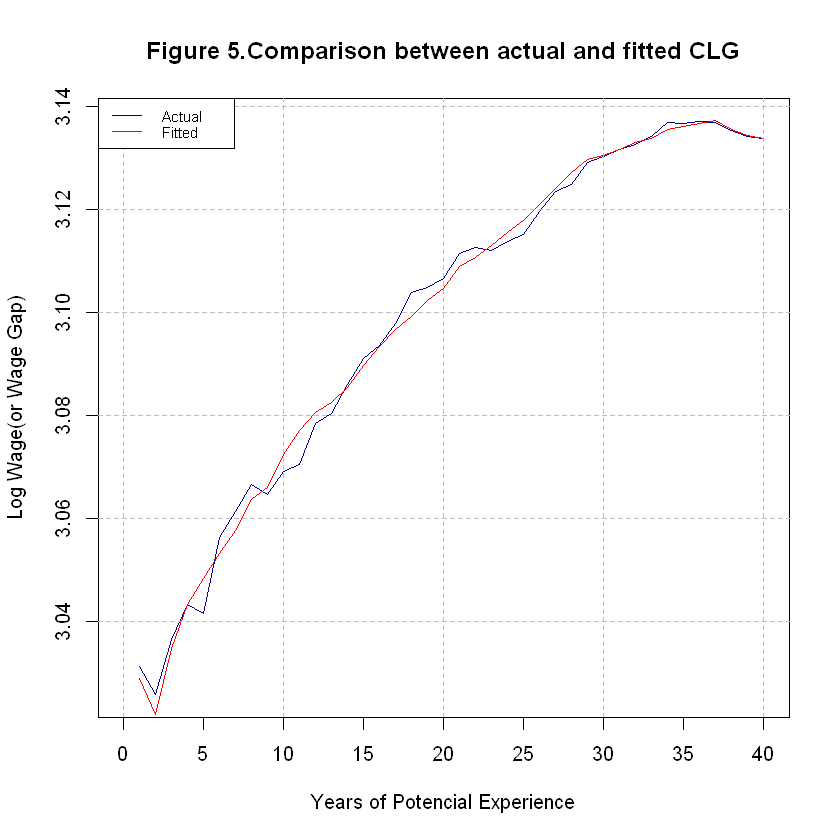

In [212]:
#Figure 5
plot(Tabla_clg$exp1,Tabla_clg$PromMov, xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 5.Comparison between actual and fitted CLG", 
     xlim=c(0,40), xaxt='n',type = 'l', col="darkblue")
lines(Tabla_clgP$exp1,Tabla_clgP$PromMov, col="red")
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,43,by=5))
legend(x="topleft",
       legend = c("Actual", "Fitted")
       ,col = c("darkblue", "red")
       ,cex=0.75, x.intersp=1.5, y.intersp=0.8, text.width = c(4), 
       lty=c(1,1))

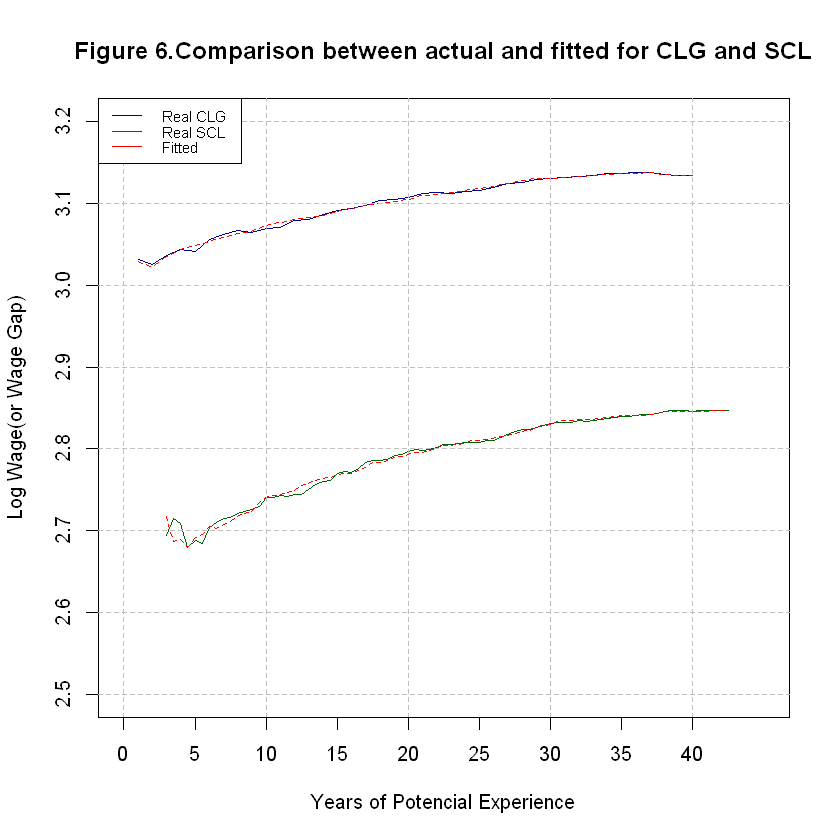

In [219]:
#Figure 6
x = Tabla_clg$exp1
x_1 = Tabla_scl$exp1
x_2= Tabla_sclP$exp1
x_3=Tabla_clgP$exp1
y = Tabla_clg$PromMov
y_1 = Tabla_scl$PromMov
y_2 = Tabla_sclP$PromMovP
y_3 = Tabla_clgP$PromMov

plot(x, y, ylim=c(2.5,3.2),type = 'l',xlab = "Years of Potencial Experience", 
     ylab="Log Wage(or Wage Gap)", main="Figure 6.Comparison between actual and fitted for CLG and SCL", xlim=c(0,45),col="darkblue" )    
lines(x_1, y_1,col="darkgreen", type = 'l')
lines (x_2,y_2, col= "red",lty = 2)
lines (x_3,y_3, col="red", lty = 2)
grid(nx = NULL, ny = NULL, lty = 2, col = "gray", lwd = 1)
axis(side = 1, at=seq(0,43,by=5))
legend(x="topleft",
       legend = c("Real CLG","Real SCL","Fitted")
       ,col = c("darkblue","darkgreen","red")
       ,cex=0.75, x.intersp=1.5, y.intersp=0.8, text.width = c(5), 
       lty=c(1,1))